# Mel-Spectrograms

__Library__

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from tqdm import tqdm
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional
from torch.utils.data import Dataset, DataLoader

from matplotlib import font_manager
font_manager._rebuild()
fontP = font_manager.FontProperties()
fontP.set_family('Microsoft JhengHei')

### Audio

__display__

In [2]:
file = 'voice_source/Aoi_1.wav'
ipd.Audio(file)

__wavform__

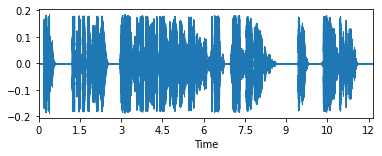

In [3]:
# loading
sample, rate = librosa.load(file)

plt.figure(figsize=(6,2))
librosa.display.waveplot(sample, sr=rate)

### Dataset

__label__

In [4]:
#columns = ['蘿莉/妹妹','御姊/女王','邪惡/病嬌','天然呆','溫和/媽媽','元氣','傲嬌','內向/弱氣','冷/無感情','男性化/英氣','調皮']
columns = ['蘿莉/妹妹','御姊/女王','溫和','元氣','男性化/英氣']
source = pd.read_csv('Anime Voice Dataset Source - labels.csv')[['character name','series','id','ambiguous']+columns]
source[:3]

,character name,series,id,ambiguous,蘿莉/妹妹,御姊/女王,溫和,元氣,男性化/英氣
0,ahoy,ahoy,ahoy,NaN,0,0,0,0,0
1,艾絲.華倫斯坦,在地下城（略）,Ais,NaN,0,0,0,0,0
2,アカメ,アカメがキール,akame,NaN,0,0,0,0,0


__audio file__

In [5]:
file_list = ['voice_source/'+file for file in os.listdir('voice_source')]
file_list2 = ['cheng_Yu-audio/'+file for file in os.listdir('cheng_Yu-audio')]
file_list3 = ['jhow-processed/'+file for file in os.listdir('jhow-processed')]
file_list = file_list + file_list2 + file_list3
print('number of file:', len(file_list))
file_list[:3]

number of file: 1008


['voice_source/Angelina_1.wav',
 'voice_source/Angelina_3.wav',
 'voice_source/Angelina_4.wav']

__dataframe__

In [6]:
df = pd.DataFrame({'file':file_list}, columns = ['character', 'series','file']+columns)

for i, value in source['id'].iteritems():
    if not pd.isna(value) or not source['ambiguous'].iloc[i] == 1:
        for j, file_name in df['file'].iteritems():
            if value in file_name:
                df.iloc[j,0] = source['character name'].iloc[i]
                df.iloc[j,1] = source['series'].iloc[i]
                df.iloc[j,3:] = source[columns].iloc[i]
df = df.dropna()
#df = df[:10]
#df[:10]

In [7]:
df.shape

(979, 8)

## Data Preprocessing

__feature dataset__

In [8]:
import os

class FeatureSet():
    def __init__(self, df, columns, root=None, transform=None, sec = 5, stride = 3, sr = 22050, n_fft = 2048, hop_length=512, n_mels = 90):
        self.sources = []
        self.X_spec = []
        self.X_feature = []

        self.y = []
        self.columns = columns
        
        self.size = sec*sr
        self.stride = stride*sr
        self.transform = transform
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        
        self.shape = (self.n_mels, math.floor(self.size/self.hop_length) + 1)

        if(root == None or root == "notsave"):
            for index, row in tqdm(df.iterrows(), total=df.shape[0]):

                # load audio
                file = row['file']
                audio, _ = librosa.load(row['file'], sr = self.sr)


                for seg in range( math.ceil((len(audio)-self.size)/self.stride + 1) ):
                    sample = audio[self.stride*seg:(self.stride*seg+self.size)]

                    if len(sample) > self.size * 0.6:

                        # padding & trimming & normalization
                        sample = librosa.util.fix_length(sample, size = self.size)
                        sample_norm = self.normalize(sample)

                        # extract mel-spectrogram
                        mel_spec = self.mel_spectrogram(sample_norm)
                        feature_vec = self.feature_vector(sample_norm)

                        # label
                        self.sources.append(row[0]+' - '+row[1])
                        self.X_spec.append(mel_spec)
                        self.X_feature.append(feature_vec)
                        self.y.append(list(row[3:].values))

            self.X_spec = torch.from_numpy(np.array(self.X_spec)).float()
            self.X_feature = torch.from_numpy(np.array(self.X_feature)).float().permute(0,2,1)
            self.y = torch.from_numpy(np.array(self.y))
            if root != "notsave":
                torch.save(self.X_spec, 'spectrum.pth')
                torch.save(self.X_feature, 'feature.pth')
                torch.save(self.y, 'label.pth')
                np.save('sources.npy',self.sources)
        else:
            self.X_spec = torch.load(os.path.join(root, 'spectrum.pth'))
            self.X_feature = torch.load(os.path.join(root, 'feature.pth'))
            self.y = torch.load(os.path.join(root, 'label.pth'))
            self.sources = np.load(os.path.join(root, 'sources.npy'))
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        if self.transform != None:
            return self.transform(self.X[index]), self.y[index]
        else:
            return self.X_spec[index], self.X_feature[index], self.y[index]
    
    def mel_spectrogram(self, sample):
        mel_spec = librosa.feature.melspectrogram(sample, sr = self.sr, n_fft = self.n_fft, hop_length=self.hop_length, n_mels = self.n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, top_db = 80.0)
        return log_mel_spec
    
    def feature_vector(self, sample):
        mfcc = librosa.feature.mfcc(sample)
        centroid = librosa.feature.spectral_centroid(sample)
        contrast = librosa.feature.spectral_contrast(sample)
        chroma = librosa.feature.chroma_stft(sample)
        
        return np.concatenate((mfcc, centroid, contrast, chroma))
    
    def normalize(self, sample, eps=1e-6):
        mean = sample.mean(); std = sample.std()
        sample_norm = (sample - mean) / (std + eps)
        return sample_norm
    
    def plot(self, index):
        plt.figure(figsize=(15,8))
        librosa.display.specshow(self.X_spec[index].numpy(), x_axis = 'time', y_axis = 'mel', sr = self.sr)
        
        if sum(list(self.y[index].numpy())) == 0:
            label = '無'
        else:
            label = self.columns[list(self.y[index].numpy()).index(1)]
        print('角色:',self.sources[index])
        print('性格:', label)
        
        plt.title('Mel-Spectrogram, label:{}'.format( self.y[index].numpy() ))
        plt.colorbar(format='%+2.f')
        plt.show()
        
featureSet = FeatureSet(df, columns, root='./')
#featureSet = FeatureSet(df, columns)
print('X mel-spec shape:\t',featureSet.X_spec.shape)
print('X feature-vec shape:\t',featureSet.X_feature.shape)
print('y label shape:   \t',featureSet.y.shape)

X mel-spec shape:	 torch.Size([2571, 90, 216])
X feature-vec shape:	 torch.Size([2571, 216, 40])
y label shape:   	 torch.Size([2571, 5])


C:\Users\User\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


角色: 安潔·天狼星 - 魔法科高校的劣等生
性格: 無


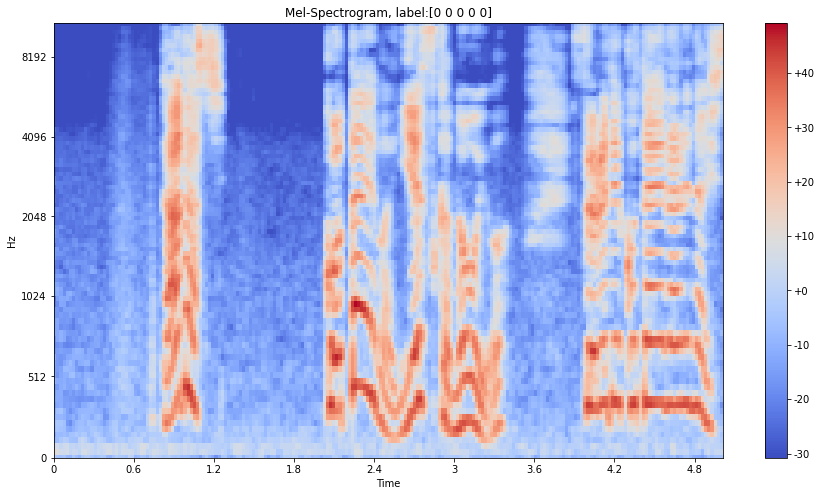

In [9]:
featureSet.plot(5)

__pytorch dataset__

In [10]:
class AhoyDataset(Dataset):
    def __init__(self, X_spec, X_feature, y, transform=None):
        self.X_spec = X_spec
        self.X_feature = X_feature
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        if self.transform != None:
            return self.transform(self.X[index]), self.y[index]
        else:
            return self.X_spec[index], self.X_feature[index], self.y[index]

# train test split
msk = np.array(range(len(featureSet))) < len(featureSet) * 0.8

train_ds = AhoyDataset(featureSet.X_spec[msk], featureSet.X_feature[msk], featureSet.y[msk])
test_ds = AhoyDataset(featureSet.X_spec[~msk], featureSet.X_feature[~msk], featureSet.y[~msk])

print('train:',len(train_ds))
print('test:',len(test_ds))

train: 2057
test: 514


__normalization__

In [11]:
spec_mean = train_ds.X_spec.mean(dim=[0,1,2])
spec_std = train_ds.X_spec.std(dim=[0,1,2])

feature_mean = train_ds.X_feature.mean(dim=[0,2])
feature_std = train_ds.X_feature.std(dim=[0,2])

train_ds.X_spec = (train_ds.X_spec - spec_mean)/spec_std
test_ds.X_spec = (test_ds.X_spec - spec_mean)/spec_std

train_ds.X_feature = (train_ds.X_feature - feature_mean[:, None])/feature_std[:, None]
test_ds.X_feature = (test_ds.X_feature - feature_mean[:, None])/feature_std[:, None]

In [45]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_ds,
                                            batch_size = batch_size,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_ds,
                                            batch_size = batch_size,
                                            shuffle = False)

## Training

### Model

In [19]:
from models import vgg16, resnet18, cnn_light, cnn, LSTM_Net
cnn_net = resnet18(num_classes=5, get_avg_layer=True)
lstm_net = LSTM_Net(input_dim = 40, hidden_dim = 128, num_layers = 1, dropout=0.5, get_hidden_layer=True)

In [14]:
def evaluation(outputs, labels):
    with torch.no_grad():
        outputs[outputs>=0.25] = 1 # 大於等於 0.5 為正面
        outputs[outputs<0.25] = 0 # 小於 0.5 為負面
        correct = torch.sum(torch.sum(torch.eq(outputs, labels),dim=1) == labels.shape[1]).item()
        correct_byclass = torch.sum(torch.eq(outputs, labels),dim=0)
    return correct, correct_byclass
class model_result():
    def __init__(self):
        self.train_loss = []
        self.valid_loss = []
        self.epoch = []

In [15]:
class Blender_Net(nn.Module):
    def __init__(self, cnn, lstm, num_classes):
        super(Blender_Net, self).__init__()
        self.cnn = cnn
        self.lstm = lstm
        self.fc = nn.Sequential(
            nn.Linear(512+256, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
    def forward(self, x_cnn, x_lstm):
        x1 = self.cnn(x_cnn)
        x2 = self.lstm(x_lstm)
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        return x
        

In [20]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_net.to('cuda')
lstm_net.to('cuda')
blender_net = Blender_Net(cnn=cnn_net, lstm=lstm_net, num_classes=5)
blender_net.to('cuda')
result_blender = model_result()

epoch = 100
optimizer = optim.Adam(blender_net.parameters(), lr=0.003, betas=(0.9,0.99), weight_decay=5e-4)
lossfn = torch.nn.BCELoss()
max_acc = 0
for i in range(epoch):
    blender_net.train()
    train_loss_sum = 0
    train_correct = 0
    train_size = 0
    for x_spec,x_feat,y in train_loader:
        x_spec, x_feat, y = x_spec.type(torch.float32).to(device), x_feat.type(torch.float32).to(device), y.type(torch.float32).to(device)
        x_spec = torch.unsqueeze(x_spec, 1)
        predict = blender_net(x_spec, x_feat)
        loss = lossfn(predict, y)
        
        train_loss_sum += loss*y.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #outputs = torch.sign(predict)
        correct,_ = evaluation(predict,y) # 計算此時模型的 validation accuracy
        train_correct += correct
        train_size += len(y)
        
        #a = ((torch.sign(predict-0.25)+1)/2+y == 2)
        #train_correct += a.sum().item()
        
        
        
    total = 0
    #correct = 0
    valid_correct = 0
    valid_size = 0
    blender_net.eval()
    loss_sum = 0
    for x_spec,x_feat,y in test_loader:
        x_spec, x_feat, y = x_spec.type(torch.float32).to(device), x_feat.type(torch.float32).to(device), y.type(torch.float32).to(device)
        x_spec = torch.unsqueeze(x_spec, 1)
        predict = blender_net(x_spec, x_feat)
        loss = lossfn(predict, y)
        loss_sum += loss.item()*y.shape[0]
        total += len(y)
        #a = ((torch.sign(predict-0.25)+1)/2+y == 2)
        #correct += a.sum().item()
        #utputs = torch.sign(predict)
        correct,_ = evaluation(predict, y) # 計算此時模型的 validation accuracy
        valid_correct += correct
        valid_size += len(y)
    if valid_correct/valid_size > max_acc:
        max_acc = valid_correct/valid_size
        torch.save(blender_net.state_dict(), 'blender_model.pth')
        print(max_acc)
    result_blender.epoch.append(i)
    result_blender.train_loss.append(train_loss_sum/len(train_loader.dataset)) 
    result_blender.valid_loss.append(loss_sum/total)
    print('(epoch %d) Train Acc: %.3f%% (%d/%d), Test Acc: %.3f%% (%d/%d), Training Loss: %.3f, Testing Loss: %.3f' % (i, 100*train_correct/train_size, train_correct, train_size, 100.0*valid_correct/valid_size, valid_correct, valid_size, train_loss_sum/len(train_loader.dataset),loss_sum/total))

0.16342412451361868
(epoch 0) Train Acc: 5.056% (104/2057), Test Acc: 16.342% (84/514), Training Loss: 0.592, Testing Loss: 0.616
(epoch 1) Train Acc: 8.605% (177/2057), Test Acc: 0.000% (0/514), Training Loss: 0.508, Testing Loss: 0.658
(epoch 2) Train Acc: 12.299% (253/2057), Test Acc: 2.140% (11/514), Training Loss: 0.482, Testing Loss: 0.742
(epoch 3) Train Acc: 15.946% (328/2057), Test Acc: 6.226% (32/514), Training Loss: 0.459, Testing Loss: 0.731
(epoch 4) Train Acc: 17.647% (363/2057), Test Acc: 7.782% (40/514), Training Loss: 0.456, Testing Loss: 0.741
(epoch 5) Train Acc: 20.369% (419/2057), Test Acc: 6.420% (33/514), Training Loss: 0.437, Testing Loss: 0.637
(epoch 6) Train Acc: 22.265% (458/2057), Test Acc: 7.588% (39/514), Training Loss: 0.420, Testing Loss: 0.770
(epoch 7) Train Acc: 21.147% (435/2057), Test Acc: 10.895% (56/514), Training Loss: 0.431, Testing Loss: 0.530
(epoch 8) Train Acc: 22.557% (464/2057), Test Acc: 7.198% (37/514), Training Loss: 0.412, Testing Los

(epoch 72) Train Acc: 90.812% (1868/2057), Test Acc: 19.650% (101/514), Training Loss: 0.047, Testing Loss: 1.229
(epoch 73) Train Acc: 92.562% (1904/2057), Test Acc: 19.261% (99/514), Training Loss: 0.041, Testing Loss: 1.287
(epoch 74) Train Acc: 92.756% (1908/2057), Test Acc: 18.093% (93/514), Training Loss: 0.039, Testing Loss: 1.175
(epoch 75) Train Acc: 94.166% (1937/2057), Test Acc: 19.066% (98/514), Training Loss: 0.033, Testing Loss: 1.685
(epoch 76) Train Acc: 91.201% (1876/2057), Test Acc: 17.704% (91/514), Training Loss: 0.044, Testing Loss: 1.366
(epoch 77) Train Acc: 88.284% (1816/2057), Test Acc: 16.537% (85/514), Training Loss: 0.060, Testing Loss: 1.488
(epoch 78) Train Acc: 90.472% (1861/2057), Test Acc: 20.233% (104/514), Training Loss: 0.050, Testing Loss: 1.325
0.22178988326848248
(epoch 79) Train Acc: 94.458% (1943/2057), Test Acc: 22.179% (114/514), Training Loss: 0.032, Testing Loss: 1.347
(epoch 80) Train Acc: 94.895% (1952/2057), Test Acc: 18.288% (94/514), Tr

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_net.to('cuda')
lstm_net.to('cuda')

total = 0
#correct = 0
valid_correct = 0
valid_correct_byclass = torch.zeros((5))
valid_size = 0
blender_net = Blender_Net(cnn=cnn_net, lstm=lstm_net, num_classes=5)
blender_net.to('cuda')
blender_net.load_state_dict(torch.load('blender_model.pth'))
blender_net.eval()
loss_sum = 0

for i, (x_spec,x_feat,y) in enumerate(test_loader):
    x_spec, x_feat, y = x_spec.type(torch.float32).to(device), x_feat.type(torch.float32).to(device), y.type(torch.float32).to(device)
    x_spec = torch.unsqueeze(x_spec, 1)
    predict = blender_net(x_spec, x_feat)
    total += len(y)
    #a = ((torch.sign(predict-0.25)+1)/2+y == 2)
    #correct += a.sum().item()
    #utputs = torch.sign(predict)
    correct, correct_byclass = evaluation(predict, y) # 計算此時模型的 validation accuracy
    valid_correct += correct
    valid_correct_byclass += correct_byclass.cpu()
    valid_size += len(y)
    if i == 0:
        predicts = predict
    else:
        predicts = torch.cat([predicts,predict],0)
print('Test Acc: %.3f%% (%d/%d)' % (100.0*valid_correct/valid_size, valid_correct, valid_size))
print(valid_correct_byclass/valid_size)

Test Acc: 22.957% (118/514)
tensor([0.7471, 0.7412, 0.5914, 0.7568, 0.8580])


In [50]:
predicts.cpu().detach().numpy()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0.]], dtype=float32)

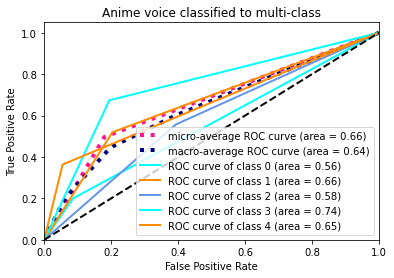

In [51]:
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
y_test = test_ds.y.numpy()
y_score = predicts.cpu().detach().numpy()
lw = 2
nlabels = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nlabels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nlabels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nlabels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nlabels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nlabels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anime voice classified to multi-class')
plt.legend(loc="lower right")
plt.show()

In [53]:
from sklearn.metrics import confusion_matrix
y_score[y_score>=0.25] = 1 # 大於等於 0.5 為正面
y_score[y_score<0.25] = 0
confision_mats = []
for j in range(nlabels):
    confision_mats.append(confusion_matrix(y_test[:,j], y_score[:,j]))

In [54]:
for j in range(nlabels):
    print(columns[j], "acc:", (confision_mats[j][0,0] + confision_mats[j][1,1]) / len(y_test))
    

蘿莉/妹妹 acc: 0.7470817120622568
御姊/女王 acc: 0.7412451361867705
溫和 acc: 0.5914396887159533
元氣 acc: 0.7568093385214008
男性化/英氣 acc: 0.857976653696498


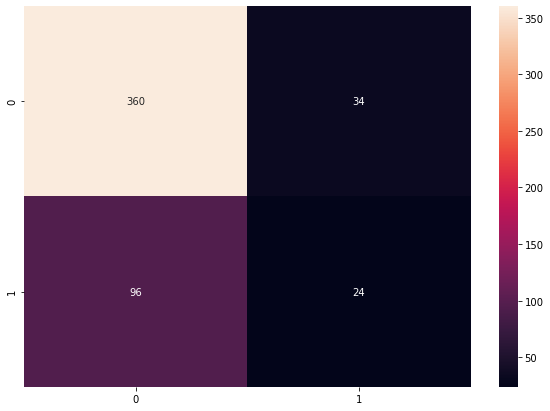

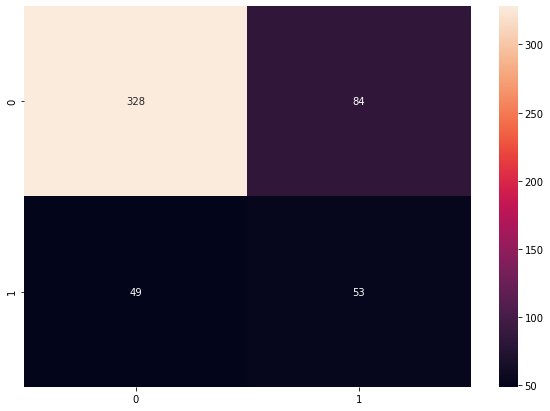

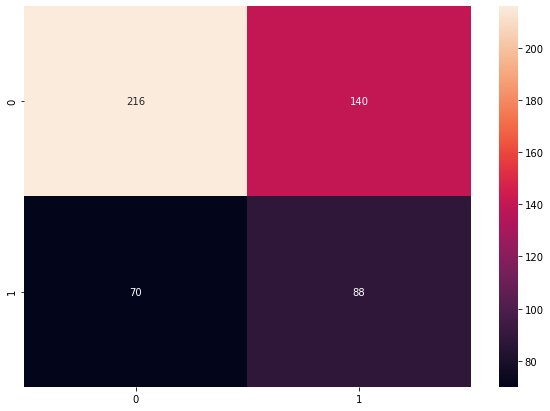

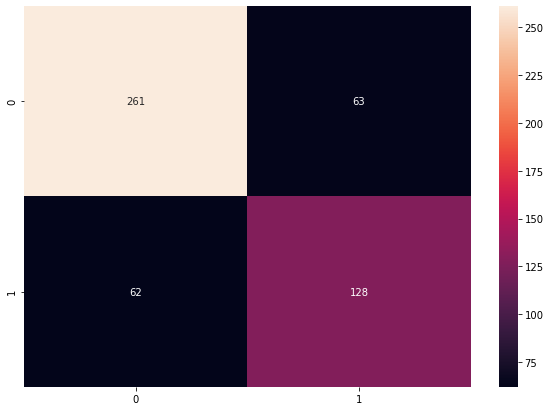

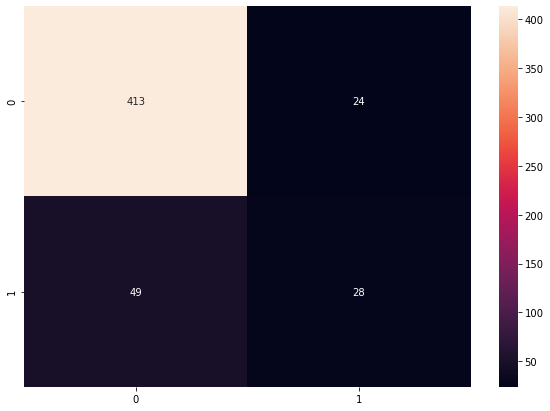

In [55]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
for j in range(nlabels):
    df_cm = pd.DataFrame(confision_mats[j], index = ["0", "1"],
                      columns = ["0", "1"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt="d")

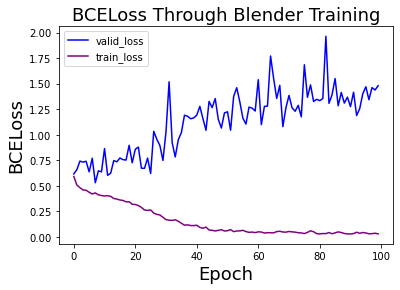

In [57]:
colors = ['blue','purple']
plt.plot(result_blender.epoch,result_blender.valid_loss,color=colors[0], label='valid_loss')
plt.plot(result_blender.epoch,result_blender.train_loss,color=colors[1], label='train_loss')

plt.title('BCELoss Through Blender Training',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('BCELoss',fontsize=18)
plt.legend()
plt.show()

In [60]:
def datasets_for_testing(file_list, normalized_para, columns):
    test_ds_groups = []
    df_group = pd.DataFrame({'file':file_list}, columns = ['character', 'series','file']+columns)

    for i, value in source['id'].iteritems():
        if not pd.isna(value):
            for j, file_name in df_group['file'].iteritems():
                if value in file_name:
                    df_group.iloc[j,0] = source['character name'].iloc[i]
                    df_group.iloc[j,1] = source['series'].iloc[i]
                    df_group.iloc[j,3:] = source[columns].iloc[i]
    df_group = df_group.dropna()

    for ind, row in df_group.iterrows():
        df_temp = row.to_frame().T
        featureSet_group = FeatureSet(df_temp, columns, root="notsave")
        test_ds_group = AhoyDataset(featureSet_group.X_spec, featureSet_group.X_feature, featureSet_group.y)

        test_ds_group.X_spec = (test_ds_group.X_spec - normalized_para[0])/normalized_para[1]
        test_ds_group.X_feature = (test_ds_group.X_feature - normalized_para[2][:, None])/normalized_para[3][:, None]
        test_ds_groups.append(test_ds_group)
    return test_ds_groups

def evaluation_mean(outputs, labels, model_type, threshold):
    with torch.no_grad():
        if model_type == "lstm":
            if outputs.nelement() > 5:
                output = torch.mean(outputs,dim=0)
            else:
                output = outputs
        elif model_type == 'cnn':
            output = torch.mean(outputs,dim=0)
        elif model_type == 'blender':
            output = torch.mean(outputs,dim=0)
        output[output>=threshold] = 1
        output[output<threshold] = 0
        print(output,labels[0])
        correct = torch.sum(torch.eq(output, labels[0])) == labels.shape[1]
    return output, correct.item()
        
def testing(test_ds_groups, model, model_type, device, threshold):
    corrects = []
    y_pred = []
    y_true = []
    one = True
    model.eval()
    model.to(device)
    with torch.no_grad():
        for test_ds_group in test_ds_groups:
            test_loader_group = torch.utils.data.DataLoader(dataset = test_ds_group,
                                                            batch_size = 100,
                                                            shuffle = False)
            for x1,x2, labels in test_loader_group:
                labels = labels.type(torch.float32).to(device)
                if model_type == "cnn":
                    inputs = x1.to(device, dtype=torch.float)
                    inputs = torch.unsqueeze(inputs, 1)
                    outputs = model(inputs)
                elif model_type == "lstm":
                    inputs = x2.permute(0,2,1).to(device, dtype=torch.float)
                    outputs = model(inputs).squeeze()
                elif model_type == 'blender':
                    x1, x2, labels = x1.type(torch.float32).to(device), x2.type(torch.float32).to(device), labels.type(torch.float32).to(device)
                    x1 = torch.unsqueeze(x1, 1)
                    outputs = blender_net(x1, x2)
                output, correct = evaluation_mean(outputs, labels, model_type, threshold)
                corrects.append(correct)
                if one:
                    one = False
                    y_pred = output.unsqueeze(0)
                    y_true = labels[0].unsqueeze(0)
                else:
                    y_pred = torch.cat((y_pred, output.unsqueeze(0)), 0)
                    y_true = torch.cat((y_true, labels[0].unsqueeze(0)), 0)
    y_pred[y_pred>=threshold] = 1
    y_pred[y_pred<threshold] = 0
    return y_pred.cpu().detach().numpy(), y_true.cpu().detach().numpy(), (sum(corrects) / len(corrects))

In [61]:
file_list4 = ['testing_source/'+file for file in os.listdir('testing_source')]
normalized_para = [spec_mean, spec_std, feature_mean, feature_std]
datasets = datasets_for_testing(file_list4, normalized_para, columns)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


In [115]:
print(datasets[12].y)

tensor([[0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1]], dtype=torch.int32)


In [62]:
from sklearn.metrics import confusion_matrix
nlabels = 5
y_pred_blender, y_true_blender, acc_blender = testing(datasets, model = blender_net, model_type = "blender", device = device, threshold = 0.25)

confision_mats_blender = []
for j in range(nlabels):
    confision_mats_blender.append(confusion_matrix(y_true_blender[:,j], y_pred_blender[:,j]))
print("Blender")
print("EM:", acc_blender)
for j in range(nlabels):
    print(columns[j], "acc:", (confision_mats_blender[j][0,0] + confision_mats_blender[j][1,1]) / len(y_true_blender))

tensor([0., 0., 1., 0., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 0., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 0., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0.], device='cuda:0') tensor([0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 0., 0.], device='cuda:0') tensor([0., 1., 1., 0., 0.], devic

tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 1., 0.], device='cuda:0') tensor([0., 1., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 0., 1.], device='cuda:0') tensor([0., 1., 0., 0., 1.], device='cuda:0')
Blender
EM: 0.18
蘿莉/妹妹 acc: 0.88
御姊/女王 acc: 0.62
溫和 acc: 0.66
元氣 acc: 0.67
男性化/英氣 acc: 0.84
